# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    """
    YOUR CODE IS HERE
    """
    return 2*np.sin(w)*np.cos(w)

grad_f(np.array((1,2)))

array([ 0.90929743, -0.7568025 ])

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

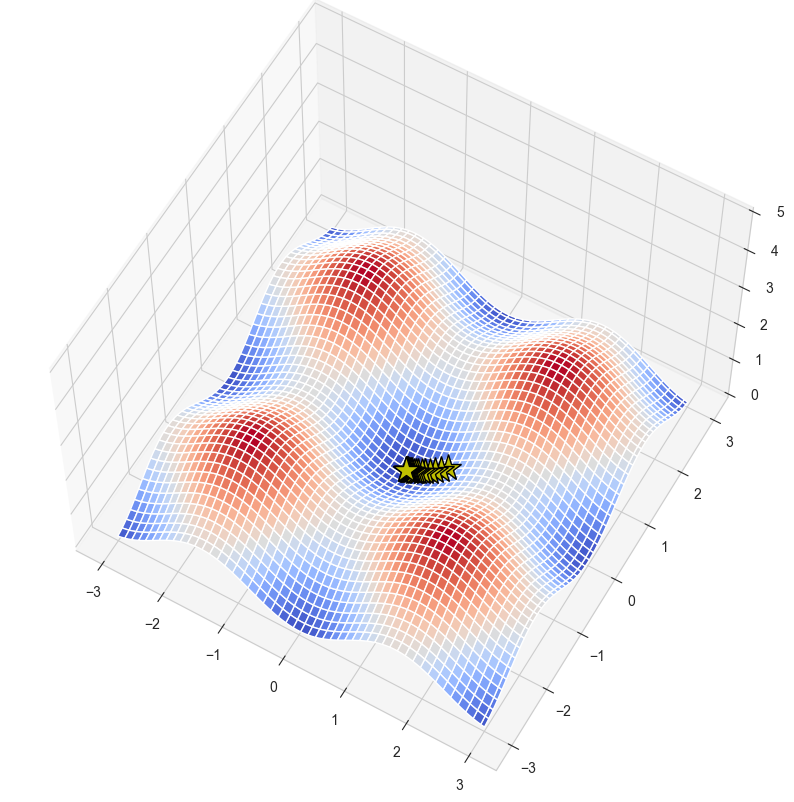

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

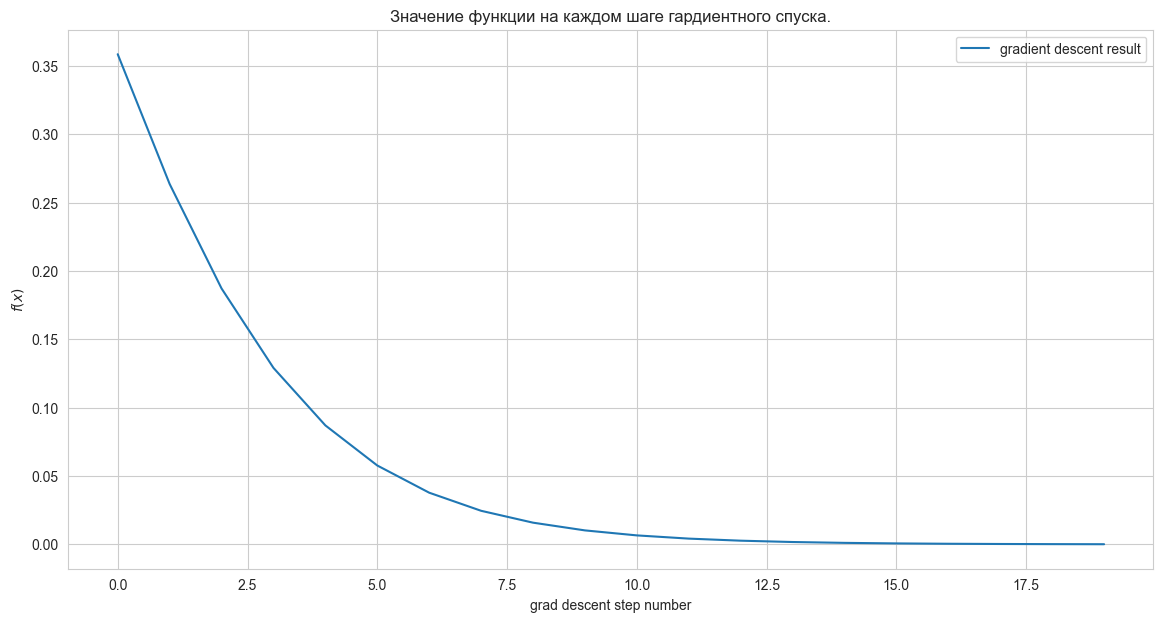

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")

    N = len(y_pred)
    mse = (np.sum((y_true - y_pred)**2))/N
    return mse

def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")

    N = len(y_pred)
    mse_grad = 2/N * np.matmul(X.T, (y_pred - y_true))
    return mse_grad

class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = np.matmul(X_test, self.W)
        return y_pred
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

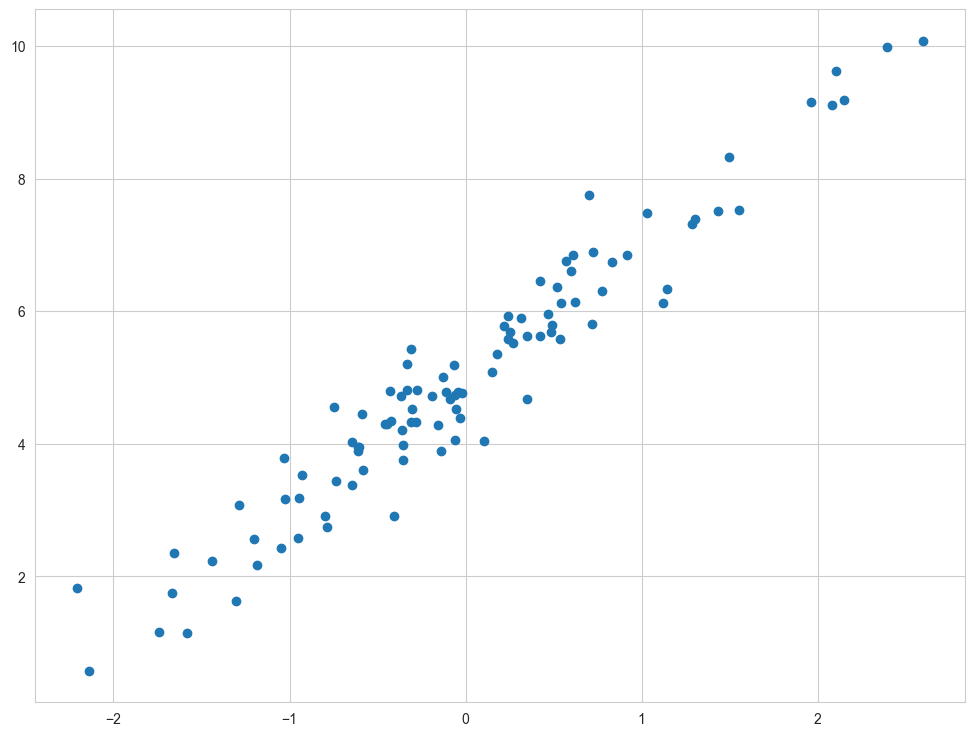

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

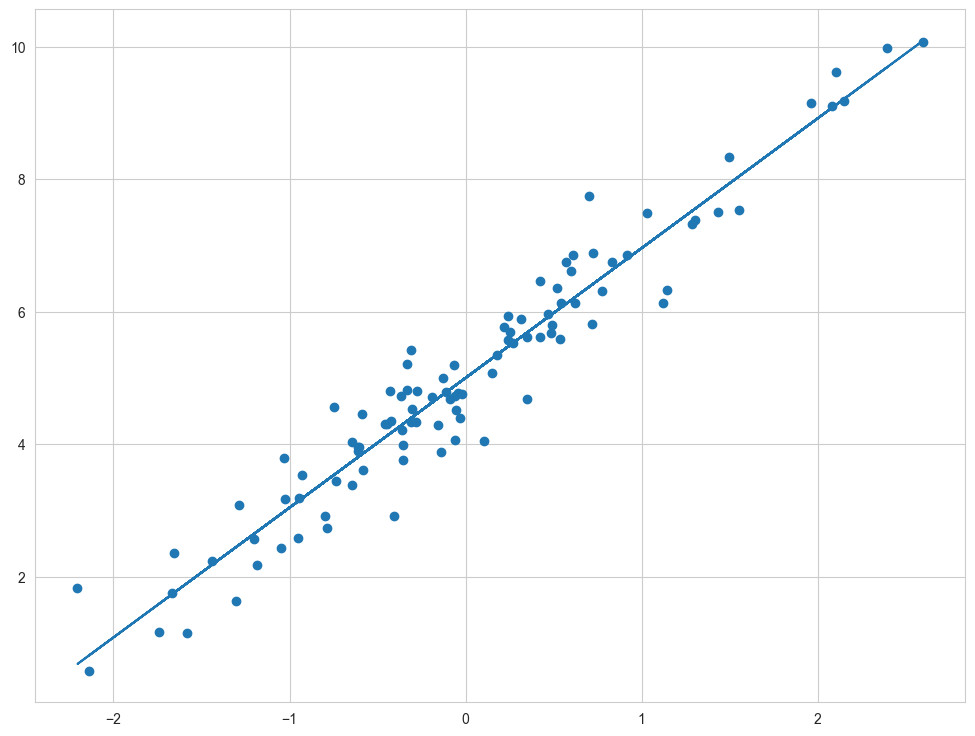

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Ваш ход:

### EDA

In [20]:
dataset = pd.DataFrame(X, columns=feature_names)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


All features are numeric (float) and there are no NA's. Seems good.

In [21]:
dataset.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Maximal values for AveRomms, AveBedrms, Population, AveOccup differe singificantly from their mean +- std, which may be due to outliers in these features. Let's have a look on the boxplots and histograms. 

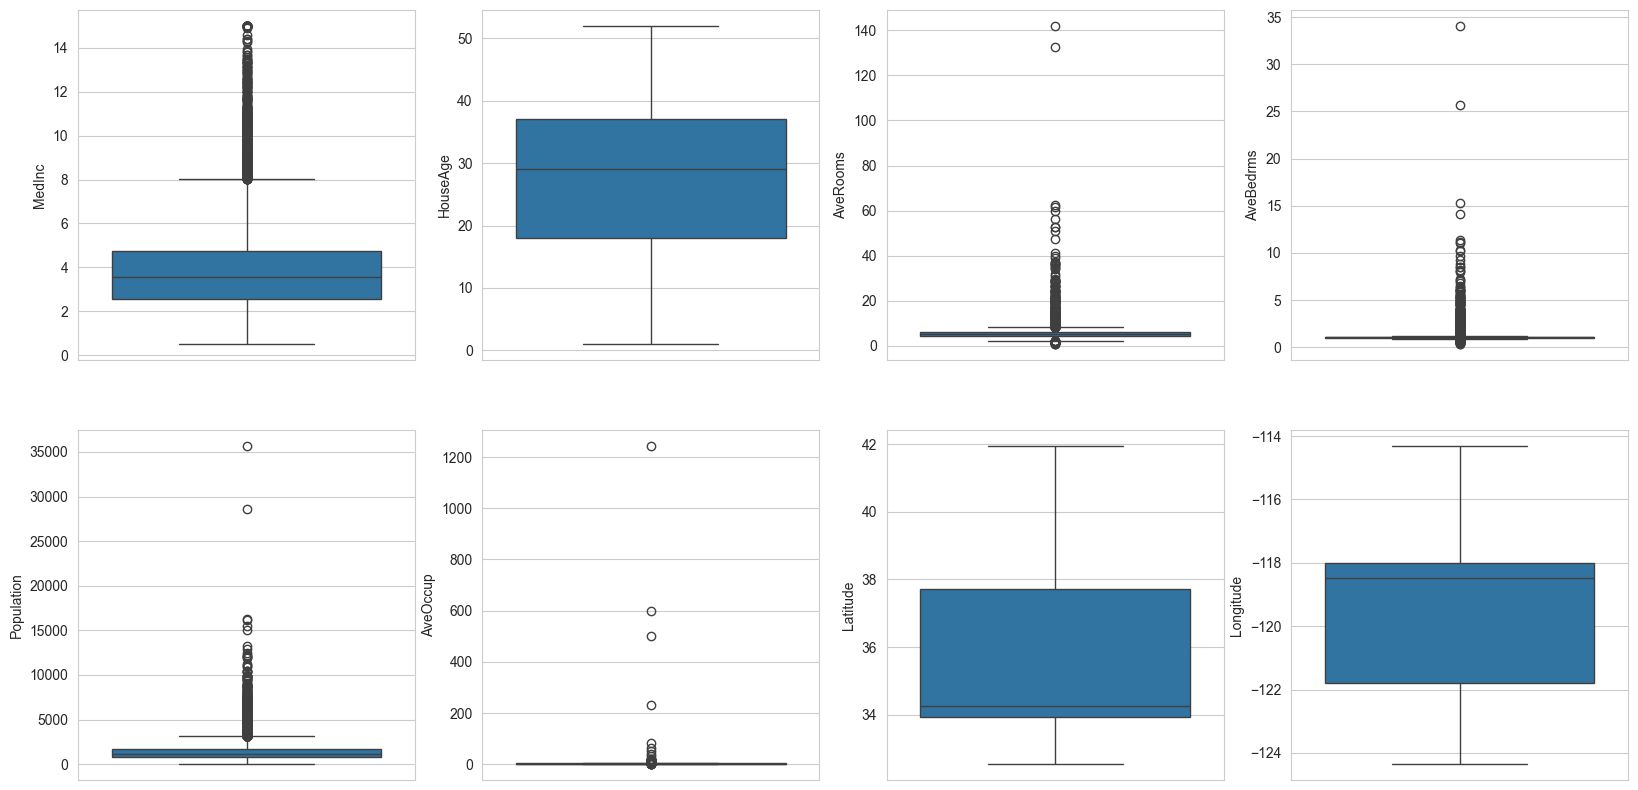

In [22]:
fig = plt.figure(figsize=(20, 10))

for i in range(1, 9):
    fig.add_subplot(2, 4, i)
    sns.boxplot(dataset[dataset.columns[i-1]])
plt.show()

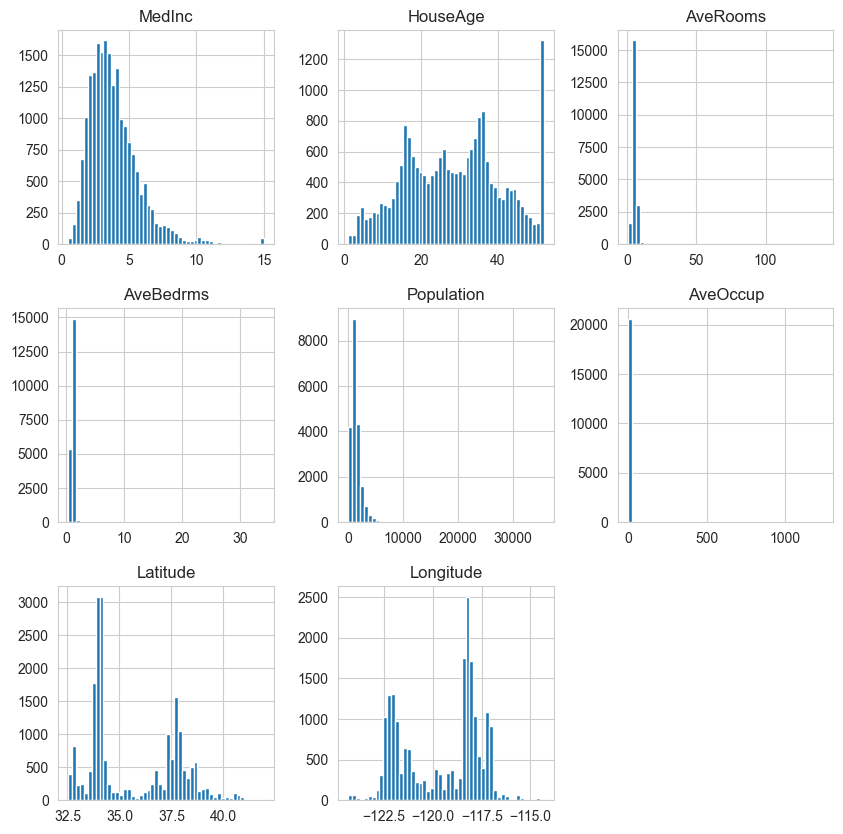

In [23]:
dataset.hist(bins=50, figsize=(10,10))
plt.show()

Yes, there are outliers in abovementioned groups. 

In .describe() we obtained 75 percentiles, so let's look how many values are over 75 percentile in these features. 

In [24]:
outliers = {'AveRooms' : round(dataset[dataset['AveRooms'] > 6.05].shape[0] / dataset.shape[0], 2),
           'AveBedrms' : round(dataset[dataset['AveBedrms'] > 1.1].shape[0] / dataset.shape[0], 2),
           'Population' : round(dataset[dataset['Population'] > 1725].shape[0] / dataset.shape[0], 2),
           'AveOccup' : round(dataset[dataset['AveOccup'] > 3.28].shape[0] / dataset.shape[0], 2)
           }
outliers

{'AveRooms': 0.25, 'AveBedrms': 0.25, 'Population': 0.25, 'AveOccup': 0.25}

Interesting that all features contain 25% of outliers. This is actually huge amount of data and might be usefull for our model. I think that we cannot delete them.

But what we actually must to - it is data scaling. Here we have very different features by their values, that's why we must scale them. 

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(dataset, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=SEED)

In [26]:
# Data scaling
preprocessor = ColumnTransformer(transformers=[
    ('StandardScaler', StandardScaler(), feature_names)
])
preprocessor

ColumnTransformer(transformers=[('StandardScaler', StandardScaler(),
                                 ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                                  'Population', 'AveOccup', 'Latitude',
                                  'Longitude'])])

In [27]:
# Pipeline creation
ml_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LinearRegression(n_jobs=4))
])
ml_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude',
                                                   'Longitude'])])),
                ('model', LinearRegression(n_jobs=4))])

In [28]:
# Model fitting and prediction
ml_pipeline.fit(X_train, y_train)
y_pred = ml_pipeline.predict(X_test)

coefficients = ml_pipeline.named_steps['model'].coef_
coefficients

array([ 0.82824232,  0.12153239, -0.26117647,  0.30524043, -0.00653505,
       -0.03964943, -0.888757  , -0.85848682])

In [29]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
f'MSE: {round(mse, 3)}, r2: {round(r2, 3)}'

'MSE: 0.541, r2: 0.596'

According to these results, I think that *Population* and *AveOccup* have very insignificant input to the model, because their coefficients are very near to 0. *MedInc*, *Latitude*, *Longitude* have the highest impact out of all features

MSE coefficient is pretty low, and we usually want to minimize it. MSE is [0; +inf], so such a low value is good result. r2 coefficient is rather good, but r2 is [0;1], so 0.596 is not actually perfect.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задачах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [30]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1/(1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [31]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    BCE = -(1/y_true.shape[0])*np.sum(y_true*np.log(sigmoid(y_pred)) + (1 - y_true)*np.log(1 - sigmoid(y_pred)))
    return BCE

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    BCE_grad = np.matmul(X.T, (sigmoid(y_pred) - y_true))
    return BCE_grad

class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [32]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = sigmoid(np.matmul(X_test, self.W))
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [33]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

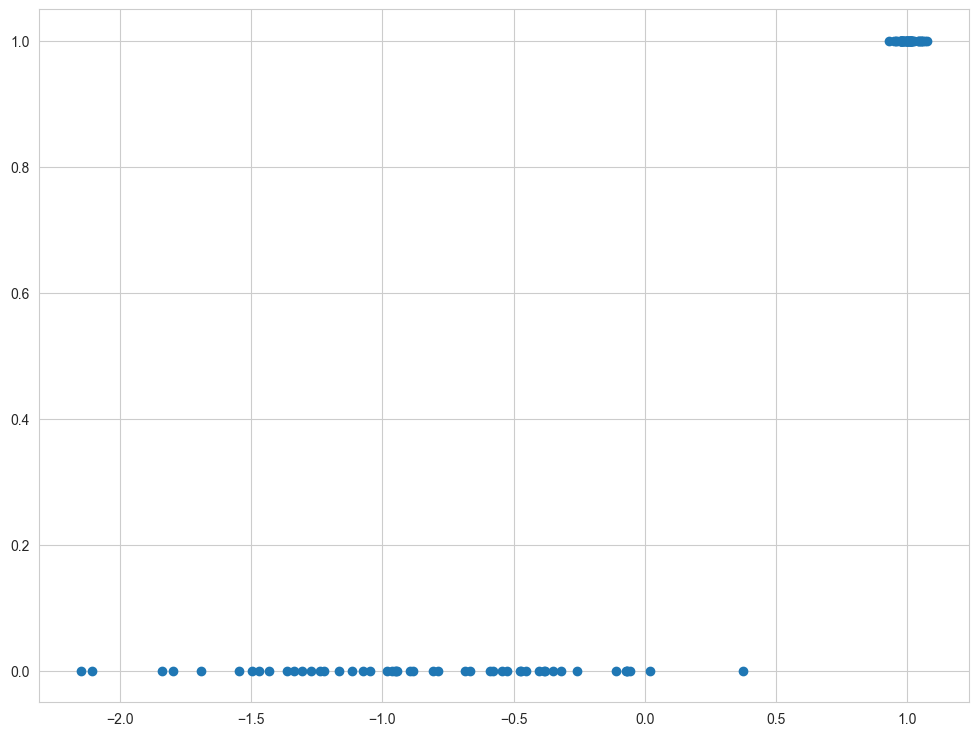

In [34]:
plt.scatter(X, y);

In [35]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

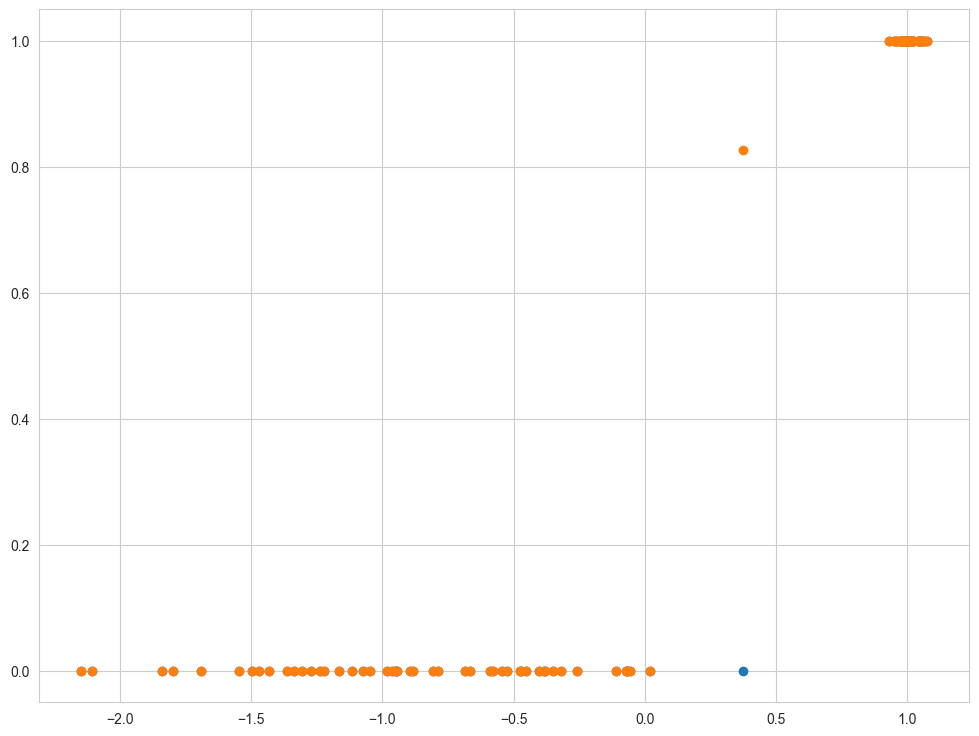

In [36]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [37]:
def binary_classification_metrics(y_pred, y_true, threshold = 0.5):
    """
    Computes metrics for binary classification
    Arguments:
    y_pred, np array (num_samples) - model predictions
    y_true, np array (num_samples) - true labels
    Returns:
    precision, recall, f1, accuracy - classification metrics
    """

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    y_pred_01 = np.where(y_pred.reshape(y_pred.shape[0],) >= threshold, 1, 0)
    
    for i in range(y_pred.shape[0]):
        if y_pred_01[i] == 1 and y_true[i] == y_pred_01[i]:
            TP += 1
        elif y_pred_01[i] == 0 and y_true[i] == y_pred_01[i]:
            TN += 1
        elif y_pred_01[i] == 1 and y_true[i] != y_pred_01[i]:
            FP += 1
        elif y_pred_01[i] == 0 and y_true[i] != y_pred_01[i]:
            FN += 1
        else:
            raise ValueError('Strange number occured')
            
    if not (TP + FN) > 0 or not (TP + FN) > 0:
        raise ValueError('Can\'t calculate metics, because division by 0 is impossible')
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    
    if not (precision + recall) >0:
        raise ValueError('Can\'t calculate f1, because division by 0 is impossible')
    
    f1 = 2*precision*recall/(precision + recall)

    return precision, recall, f1, accuracy

binary_classification_metrics(y_pred, y, threshold = 0.5)

(0.9803921568627451, 1.0, 0.99009900990099, 0.99)

All metrics are quite good, a.k.a all near 1.0. That means that out model predicts well

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [38]:
pokemon = pd.read_csv("../data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [39]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [40]:
pokemon['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [41]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


First column is actually useless - it's just indices. Also, we have several non-numeric columns with Type1 and Type2. For Type2 we have almost half of the data in NaN, so I think we can't use this column for our model. Actually, columns Type 1 and Type 2 are the same in the context of unique values. So, I propose at the first glance to work only with Type 1. There are 18 unique values, we will perform one hot encoding to transform this column.

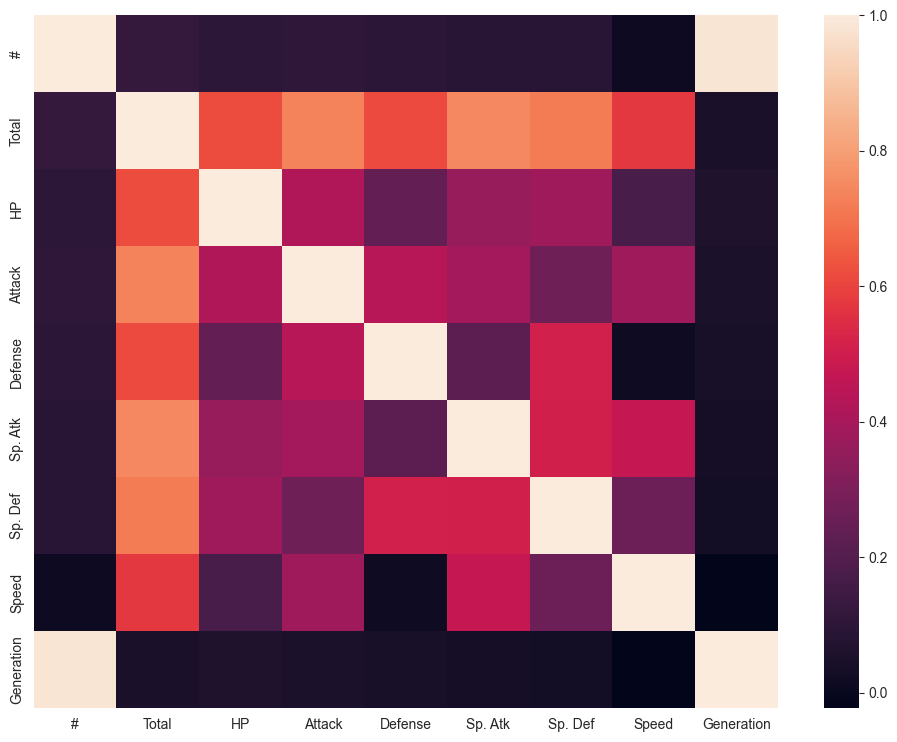

In [42]:
sns.heatmap(pokemon.select_dtypes(include=np.number).corr());


Total highly correlates with almost all features. It might happen that we will have to exclude some highly correlated columns, but for the first glance let's use all of them. Almost all other features have correlation middle (0.3-0.7) correlation or lower, which is good for our analysis.

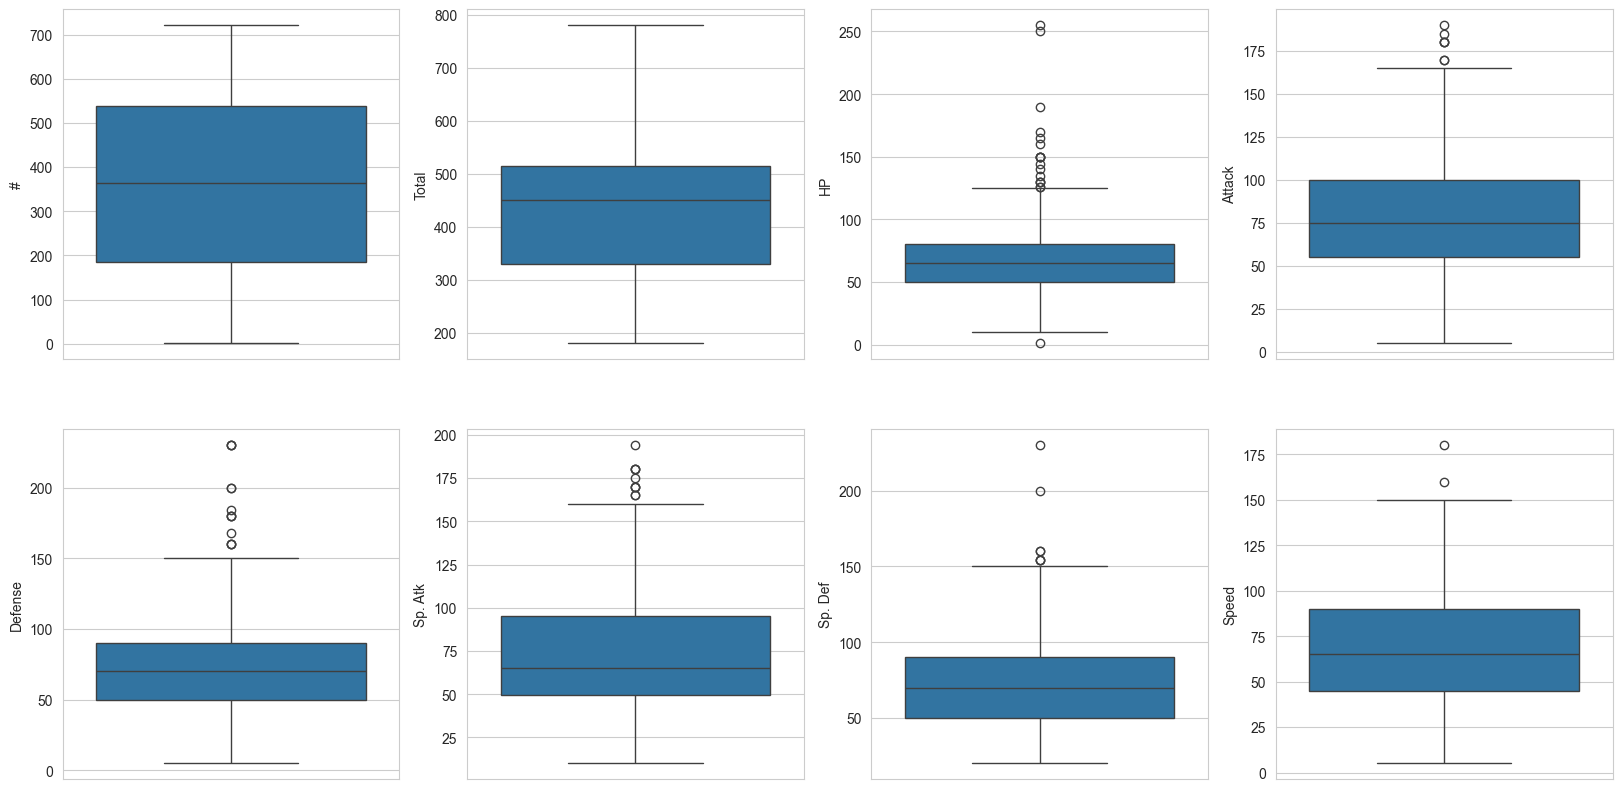

In [43]:
fig = plt.figure(figsize=(20, 10))

for i in range(1, 9):
    fig.add_subplot(2, 4, i)
    sns.boxplot(pokemon[pokemon.select_dtypes(include=np.number).columns[i-1]])
plt.show()

HP column contain some outliers, but other columns are more or less okay. It should not be the panacea to delete outliers, because they may carry some important information. Let's check how many outliers are there over 3rd quartile.

In [44]:
round(pokemon[pokemon['HP'] > 80].shape[0] / pokemon.shape[0], 2)

0.24

It's actually 25%, so it is a big part of the data. More or less, we don't see very huge outlier, that's why for initial model we will not exclude them.

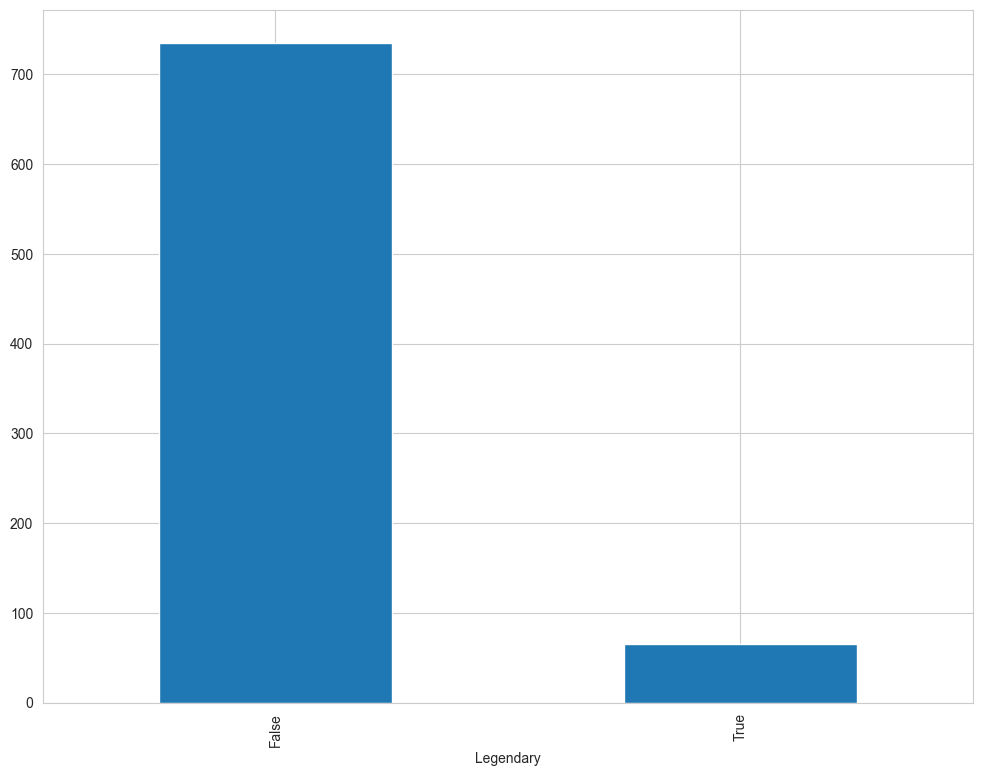

In [45]:
pokemon['Legendary'].value_counts().plot(kind = 'bar');

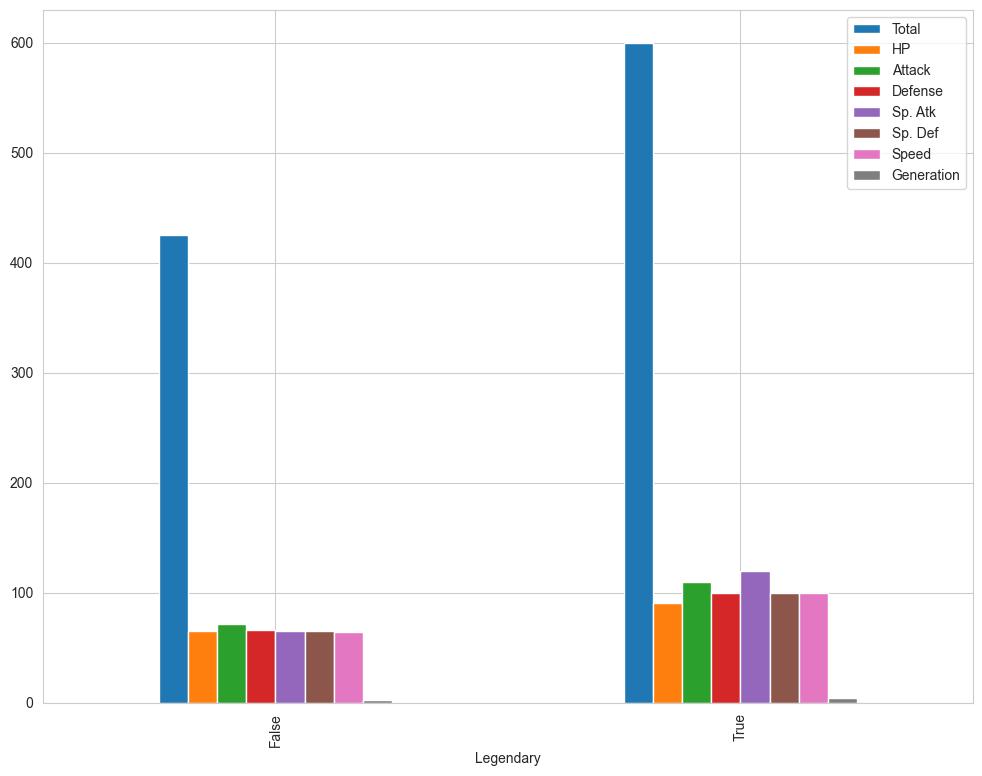

In [46]:
pokemon[['Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']].groupby('Legendary').median().plot(kind = 'bar');

Using this plot, we see that more than 90% of the data are in the False group. This is a huge imbalance and this may incorporate biad in our model. Unfortunately, we didn't dicuss such cases on the lecture. Initially, I guess that we may split the train dataset randomly and use only a part of it for the train. But I'm not sure is this idea good, so I will try first of all to build model on full data. Actually, the Pipeline will be universe and it would be possible to implmenet it to splitted train dataset. 

Finally, I delete column #, Name and Type2. # and Name do not carry information usefull for the model, Type 2 contain a lot of NAs. Actually, I may transfrom Type 2 to binary format, like if there is a value - 1, and if NA - 0. But for initial model I will delete the column. 

Of course, I will perform scaling and categorical Type 1 transformation to OHE.

Разделите ваши данные на тестовую и тренировочную выборку.

In [47]:
pokemon['Legendary'] = pokemon['Legendary'].replace([False], 0)
pokemon['Legendary'] = pokemon['Legendary'].replace([True], 1)
pokemon['Generation'] = pokemon['Generation'].astype(object)

pokemon_labels = np.array(pokemon[['Legendary']]).reshape(pokemon.shape[0])
pokemon_features = pokemon.drop(['Legendary', '#', 'Name', 'Type 2'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(pokemon_features, 
                                                    pokemon_labels, 
                                                    test_size = 0.3,
                                                    stratify = pokemon_labels, 
                                                    random_state=SEED)

/var/folders/2x/955c2pcd1cld0_8tfm105_pm0000gn/T/ipykernel_48897/3546904684.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pokemon['Legendary'] = pokemon['Legendary'].replace([True], 1)


Обучите модель `LogisticRegression` из `sklearn`.

In [48]:
# Data scaling
numeric_features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
preprocessor = ColumnTransformer(transformers=[
    ('StandardScaler', StandardScaler(), numeric_features),
    ('OHE', OneHotEncoder(), ['Type 1', 'Generation']) 
])

ml_log_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(n_jobs=4))
])
ml_log_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['Total', 'HP', 'Attack',
                                                   'Defense', 'Sp. Atk',
                                                   'Sp. Def', 'Speed']),
                                                 ('OHE', OneHotEncoder(),
                                                  ['Type 1', 'Generation'])])),
                ('model', LogisticRegression(n_jobs=4))])

In [49]:
ml_log_pipeline.fit(X_train, y_train)
y_pred = ml_log_pipeline.predict(X_test)
y_pred_proba = ml_log_pipeline.predict_proba(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [50]:
# Create ROC-curve and output the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
print(confusion_matrix(y_test, y_pred))

[[216   5]
 [ 11   8]]


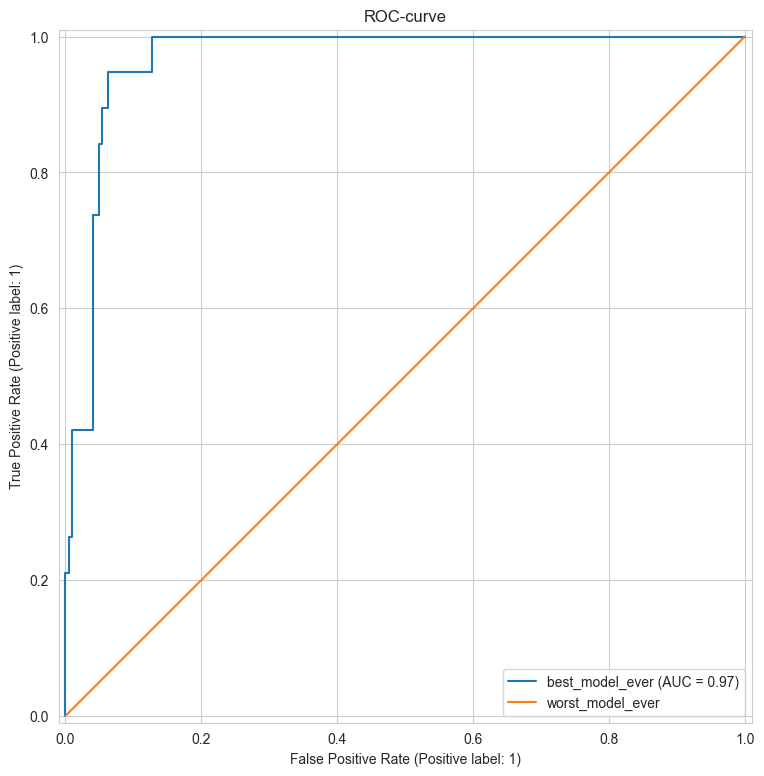

In [51]:
RocCurveDisplay.from_predictions(y_test, y_pred_proba[:,1], name="best_model_ever")
plt.plot([0, 1], [0, 1], label="worst_model_ever")
plt.title('ROC-curve')
plt.legend();

Quite well so! The AUC is quite promising. Let's also check coefficients.

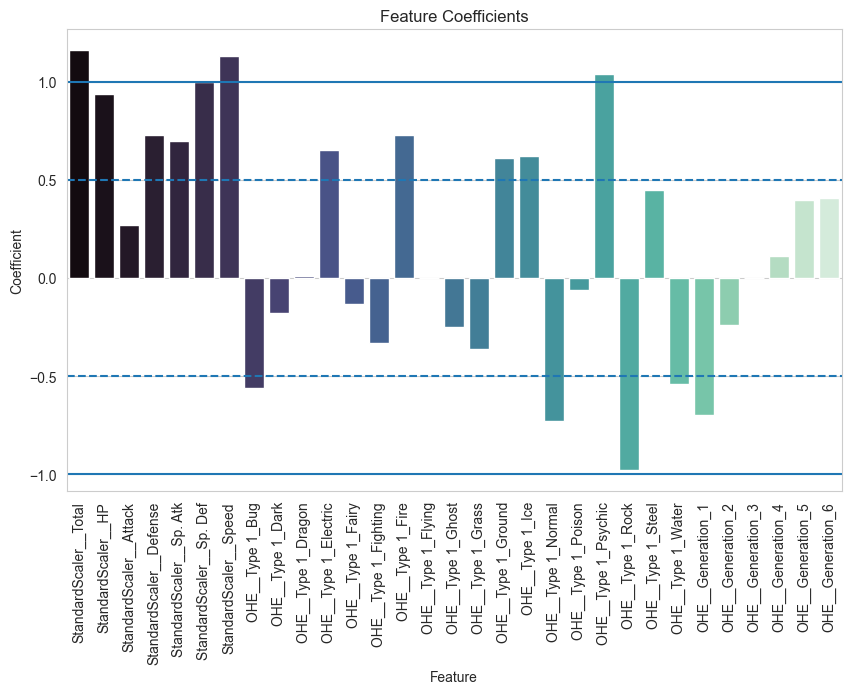

In [82]:
coef = ml_log_pipeline.named_steps['model'].coef_.flatten().round(2)
feature_names = preprocessor.get_feature_names_out()
cf_feat = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
cf_feat

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Coefficient', data=cf_feat, hue='Feature', palette='mako', legend=False)
plt.title('Feature Coefficients')
plt.axhline(y=1)
plt.axhline(y=-1)
plt.axhline(y=0.5, linestyle='--')
plt.axhline(y=-0.5, linestyle='--')
plt.xticks(rotation=45)
plt.show();

I also would like to look at the basic metrics. 

In [53]:
binary_classification_metrics(y_pred, y_test)

(0.6153846153846154, 0.42105263157894735, 0.5, 0.9333333333333333)

Metrics are not very good. This is actually due to the high imbalance in our data. There are to much observations with 0 label. So I have increased the test sample size from 0.2 to 0.3, metrics became a little bit better - you may see them (precision, recall, F1, accuracy). 

Hoooray! Finally we get coefficients. More or less, almost all coefficients are significant (not around 0). Seems that **Total** **HP** **Sp.Def** **Speed** are significant ones. Also from Type 1, pokemon being **Psych** or **Rock** is associated with the being Legendary or not.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Eminem - Till I collapse, Without Me \
Да и вообще практически все у Эминема, ахахах))) \
Недавно начал переслушивать IOWA - 140, Мама, Песня простая

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Не хватает понимания, что делать в EDA. В целом задание классное, интересное. 